<a href="https://colab.research.google.com/github/SLTHRN/Heart_disease_ML/blob/main/Project_v_1_neuron_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
### IMPORT LIBRARIES

import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sklearn

import time

In [18]:
### IMPORTING CSV FILE FROM GOOGLE DRIVE

import csv
from google.colab import drive
drive.mount('/content/drive')

#FILE LOCATION IN GOOGLE DRIVE
directory = '/content/drive/MyDrive/APS360PROJECT/New data.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
### DEFINING FULLY CONNECTED NEURAL NETWORK

import torch
import torch.nn as nn
import torch.nn.functional as F

#DEFINING A 3 LAYER FULLY CONNECTED MODEL
class neuralNetwork(nn.Module):

  def __init__(self):
    super(neuralNetwork, self).__init__()
    self.layer1 = nn.Linear(13,100)
    self.layer2 = nn.Linear(100,200)
    self.layer3 = nn.Linear(200,1)

  def forward(self, x):
    #x = x.squeeze()
    activation1 = self.layer1(x)
    activation1 = F.relu(activation1)
    activation2 = F.relu(self.layer2(activation1))
    output = self.layer3(activation2)
    return output

In [20]:
### LOADING CSV FILE FROM DIRECTORY

def load_csv(directory):
  file = open(directory, "r")
  retrieved = csv.reader(file)

  data_size = -1
  dictionary = {}
  data = []

  for row in retrieved:
    data_size+= 1
    if data_size == 0:
      for i in range(len(row)):
        dictionary[i] = row[i]
    else:
      data.append(row)

  return data_size, data, dictionary

In [21]:
### DATA STRING TO FLOAT

def str_to_flt(data):
  fail_count = 0

  for i in range(len(data)):
    row = data[i]
    new_row = []
    for j in range(len(row)):
      if row[j].isnumeric():
        new_row.append(float(row[j]))
      else:
        test = row[j].split('.')
        if len(test) == 2 and (test[0].isnumeric() and test[1].isnumeric()):
          new_row.append(float(row[j]))
        else:
          fail_count += 1
          print('!!!!!! Not Numeric, count:' + str(fail_count))
          new_row.append(row[j])
    data[i] = new_row
  return data

In [22]:
### GET LABELS

def seperate_labels(data):
  labels = []

  for row in data:
    labels.append(int(row[-1]))
    del row[-1]

  labels = get_binary(labels)

  return data, labels

In [23]:
### TURN LABELS INTO BINARY CLASSES

def get_binary(labels):
  new_labels = []
  for label in labels:
    if label == 0.0:
      new_labels.append(0.0)
    else:
      new_labels.append(1.0)
  return new_labels


In [24]:
### GENERATING SAMPLERS FOR DATALOADERS

def get_samplers(data_size):
  torch.manual_seed(0)
  index = torch.randperm(data_size)
  end_training = int(len(index)*0.6) # Defining index for last data sample in training data
  end_validation = end_training + int(len(index)*0.2) # Defining index for last data sample in validation set

  training_sampler, validation_sampler, testing_sampler = index[:end_training], index[end_training:end_validation], index[end_validation:]

  return training_sampler, validation_sampler, testing_sampler

In [25]:
### GENERATING DATA LOADERS

def get_loaders(data, sampler, batch_size = 64):
  dataset = torch.tensor(data)

  loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, sampler=sampler)
  
  return loader

In [40]:
### CALCULATE ACCURACY OF MODEL

def get_accuracy(model, d_loader, l_loader, show_data = False, show_pred = False):
  correct = 0
  total = 0

  for (data, label) in zip(d_loader, l_loader):
    output = model(data)
    pred_list = []
    if show_data and not show_pred:
      print("The labels are: {}".format(label))
      print("The outputs are: {}".format(output))
    for i in range(len(output)):
      total += 1.0
      if output[i] >= 0.5:
        pred = 1.0
      else:
        pred = 0.0
      if pred == label[i]:
        correct += 1.0
      pred_list.append(pred)
    if show_data and show_pred:
      print("The labels are: {}".format(label))
      print("The predictions are: {}".format(pred_list))
  return correct/total

In [27]:
### MODEL TRAINING

def training(t_loader, t_label_loader, v_loader, v_label_loader, epochs=10, learning_rate=0.001):
  n = 0
  iters, losses, training_accuracy, validation_accuracy = [], [], [], []

  model = neuralNetwork()
  criterion = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  print("Starting training")
  start_time = time.time()
  for epoch in range(epochs):
    for (data, label) in zip(t_loader, t_label_loader):
      output = model(data)
      loss = criterion(output.squeeze(), label)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      iters.append(n)
      losses.append(float(loss)/batch_size)
      training_accuracy.append(get_accuracy(model, t_loader, t_label_loader))
      validation_accuracy.append(get_accuracy(model, v_loader, v_label_loader))
      n += 1

  end_time = time.time()
  print("Done training, time elapsed: {:.2f} seconds".format(end_time-start_time))
  print("Number of iterations: {}".format(iters[-1]+1))
  print("Number of epochs: {}".format(epochs))
  plt.title("Training")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Accuracies")
  plt.plot(iters, validation_accuracy, label = "Validation")
  plt.plot(iters, training_accuracy, label = "Training")
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.show

  print("Final loss: {}".format(losses[-1]))
  print("Final training accuracy: {}".format(training_accuracy[-1]))
  print("Final validation accuracy: {}".format(validation_accuracy[-1]))
  return model

In [61]:
### GET BALANCE OF DATA

def data_balance(label_loader, training = False, validation = False, testing = False, get_total = False):
  num_zeros, num_ones = 0.0, 0.0
  for batch in label_loader:
    for element in batch:
      if element == 0.0:
        num_zeros += 1.0
      elif element == 1.0:
        num_ones += 1.0
      else:
        print("Error occured, incorrect label")
  if training:
    data = "training"
  elif validation:
    data = "validation"
  elif testing:
    data = "testing"
  else:
    data = "misc."
  print("Percentage of {} data with label 1: {}%".format(data, 100*num_ones/(num_ones+num_zeros)))
  if get_total:
    print("Size of {} set: {}".format(data, (num_ones+num_zeros)))

In [71]:
### ANALYSE THE BATCHES IN A LOADER

def batchwise_balance(label_loader, training = False, validation = False, testing = False, get_total = False):
  batchwise_balance = []
  for batch in label_loader:
    num_zeros, num_ones = 0.0, 0.0
    for element in batch:
      if element == 0.0:
        num_zeros += 1.0
      elif element == 1.0:
        num_ones += 1.0
      else:
        print("Error occured, incorrect label")
    batchwise_balance.append(num_ones/(num_ones+num_zeros))
  if training:
    data = "training"
  elif validation:
    data = "training"
  elif testing:
    data = "testing"
  else:
    data = "misc."
  print("Results for {} data:".format(data))
  for i in range(len(batchwise_balance)):
    print("Percenatge of batch {} with label 1: {}%".format(i+1, (100*batchwise_balance[i])))
  if get_total:
    if training:
      data_balance(label_loader, get_total = True, training = True)
      print("Number of iterations in an epoch: {}".format(len(batchwise_balance)))
    elif validation:
      data_balance(label_loader, get_total = True, validation = True)
    elif testing:
      data_balance(label_loader, get_total = True, testing = True)
    else:
      data_balance(label_loader, get_total = True)
      print("Number of iterations in an epoch: {}".format(len(batchwise_balance)))

In [29]:
### DISPLAY DATA LOADER

def display_loader(loader):
  for stuff in loader:
    print(stuff)

Percentage of training data with label 1: 47.752808988764045%
Size of training set: 178.0
Percentage of validation data with label 1: 47.45762711864407%
Percentage of testing data with label 1: 40.0%
Starting training
Done training, time elapsed: 41.09 seconds
Number of iterations: 3600
Number of epochs: 400


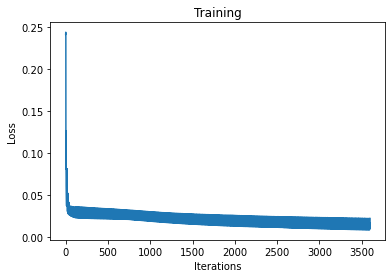

Final loss: 0.021840091049671172
Final training accuracy: 0.8820224719101124
Final validation accuracy: 0.864406779661017
Training accuracy: 0.8820224719101124
Validation accuracy: 0.864406779661017
Testing accuracy: 0.75


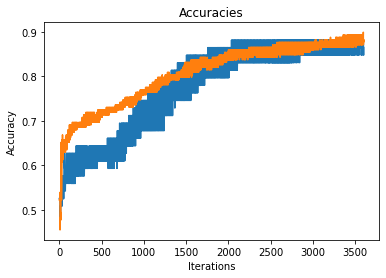

In [76]:
### RUNNING THE CODE

data_size, data, dictionary = load_csv(directory)
data = str_to_flt(data)
data, labels = seperate_labels(data)
training_sampler, validation_sampler, testing_sampler = get_samplers(data_size)

batch_size = 20
training_loader = get_loaders(data, training_sampler, batch_size)
training_label_loader = get_loaders(labels, training_sampler, batch_size)
validation_loader = get_loaders(data, validation_sampler, batch_size)
validation_label_loader = get_loaders(labels, validation_sampler, batch_size)
testing_loader = get_loaders(data, testing_sampler, batch_size)
testing_label_loader = get_loaders(labels, testing_sampler, batch_size)

data_balance(training_label_loader, training = True, get_total = True)
data_balance(validation_label_loader, validation = True)
data_balance(testing_label_loader, testing = True)

model = training(training_loader, training_label_loader, validation_loader, validation_label_loader, epochs = 400, learning_rate = 0.0001)
print("Training accuracy: {}".format(get_accuracy(model, training_loader, training_label_loader, show_data = False)))
print("Validation accuracy: {}".format(get_accuracy(model, validation_loader, validation_label_loader, show_data = False)))
print("Testing accuracy: {}".format(get_accuracy(model, testing_loader, testing_label_loader, show_data = False)))

In [42]:
get_accuracy(model, testing_loader, testing_label_loader, show_data = True, show_pred = True)

The labels are: tensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0.])
The predictions are: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
The labels are: tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
        0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1.])
The predictions are: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]


0.7166666666666667

In [73]:
batchwise_balance(training_label_loader, training = True, get_total = True)

Results for training data:
Percenatge of batch 1 with label 1: 50.0%
Percenatge of batch 2 with label 1: 55.00000000000001%
Percenatge of batch 3 with label 1: 60.0%
Percenatge of batch 4 with label 1: 25.0%
Percenatge of batch 5 with label 1: 40.0%
Percenatge of batch 6 with label 1: 55.00000000000001%
Percenatge of batch 7 with label 1: 40.0%
Percenatge of batch 8 with label 1: 50.0%
Percenatge of batch 9 with label 1: 55.55555555555556%
Percentage of training data with label 1: 47.752808988764045%
Size of training set: 178.0
Number of iterations in an epoch: 9
